<a href="https://colab.research.google.com/github/sestys/aicrowd_blitz4/blob/main/captcha_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### References:
https://github.com/carnotaur/crnn-tutorial/

[AI Crowd](https://www.aicrowd.com/challenges/ai-blitz-4/problems/captcha)

[CRNN paper](https://arxiv.org/pdf/1507.05717.pdf)

[ocr.pytorch github](https://github.com/courao/ocr.pytorch)

In [1]:
!rm -f train.tar.gz test.tar.gz
!mkdir data
!wget https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/cptcha/v0.1/train.tar.gz
!wget https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/cptcha/v0.1/test.tar.gz
!wget https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/cptcha/v0.1/train_info.csv
!wget https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/cptcha/v0.1/test_info.csv
!mkdir data/train 
!mkdir data/test
!tar -C data/ -xvzf train.tar.gz
!tar -C data/ -xvzf test.tar.gz
!mv train_info.csv data/train_info.csv
!mv test_info.csv data/test_info.csv

Streaming output truncated to the last 5000 lines.
test/image_10740.png
test/image_10599.png
test/image_10944.png
test/image_10942.png
test/image_10311.png
test/image_12929.png
test/image_10125.png
test/image_10754.png
test/image_13292.png
test/image_13604.png
test/image_11143.png
test/image_11132.png
test/image_12794.png
test/image_11851.png
test/image_13892.png
test/image_14022.png
test/image_14608.png
test/image_10727.png
test/image_12018.png
test/image_14418.png
test/image_12802.png
test/image_12989.png
test/image_11744.png
test/image_11359.png
test/image_10443.png
test/image_14213.png
test/image_14660.png
test/image_14155.png
test/image_12828.png
test/image_13899.png
test/image_13284.png
test/image_14750.png
test/image_10307.png
test/image_10270.png
test/image_13916.png
test/image_13303.png
test/image_11277.png
test/image_11819.png
test/image_10011.png
test/image_12003.png
test/image_11560.png
test/image_13615.png
test/image_12012.png
test/image_10915.png
test/image_10401.png
test

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

In [3]:
cpu_count = mp.cpu_count()
print(cpu_count)

2


In [4]:
config = {'batch_size': 32,
          'epochs': 50,
          'rnn_hidden_size': 256,
          'lr': 0.001,
          'weight_decay': 1e-3,
          'clip_norm': 5,
          }

## 1. Make train-test split

In [5]:
train_info_path = "data/train_info.csv"
test_info_path = "data/test_info.csv"

train_images_path = "data/train/"
test_images_path = "data/test/"
train_info = pd.read_csv(train_info_path)
test_info = pd.read_csv(test_info_path)

In [6]:
print('Train images:', len(glob.glob(train_images_path + '/*.png')))
print('Test images:', len(glob.glob(test_images_path + '/*.png')))

Train images: 10000
Test images: 5000


In [7]:
X_train, X_val= train_test_split(train_info, test_size=0.1, random_state=42)

In [8]:
test_info.head()

,filename
0,image_10001.png
1,image_10002.png
2,image_10003.png
3,image_10004.png
4,image_10005.png


In [9]:
def plot_image(img_path):
    img = Image.open(img_path).convert('RGB')
    rsz = transforms.Resize((50, 200))
    plt.imshow(img)
    img = rsz(img)
    print(img.size)

    plt.imshow(img)

(200, 50)
Pcyq6
(200, 50)
wJgfTmcit
(200, 50)
JNbICISQ
(200, 50)
T6CD
(200, 50)
NygTvaCNs
(200, 50)
fWAK
(200, 50)
Ml4nOT8m
(200, 50)
OmA1zMy
(200, 50)
EVp9lGAmLu


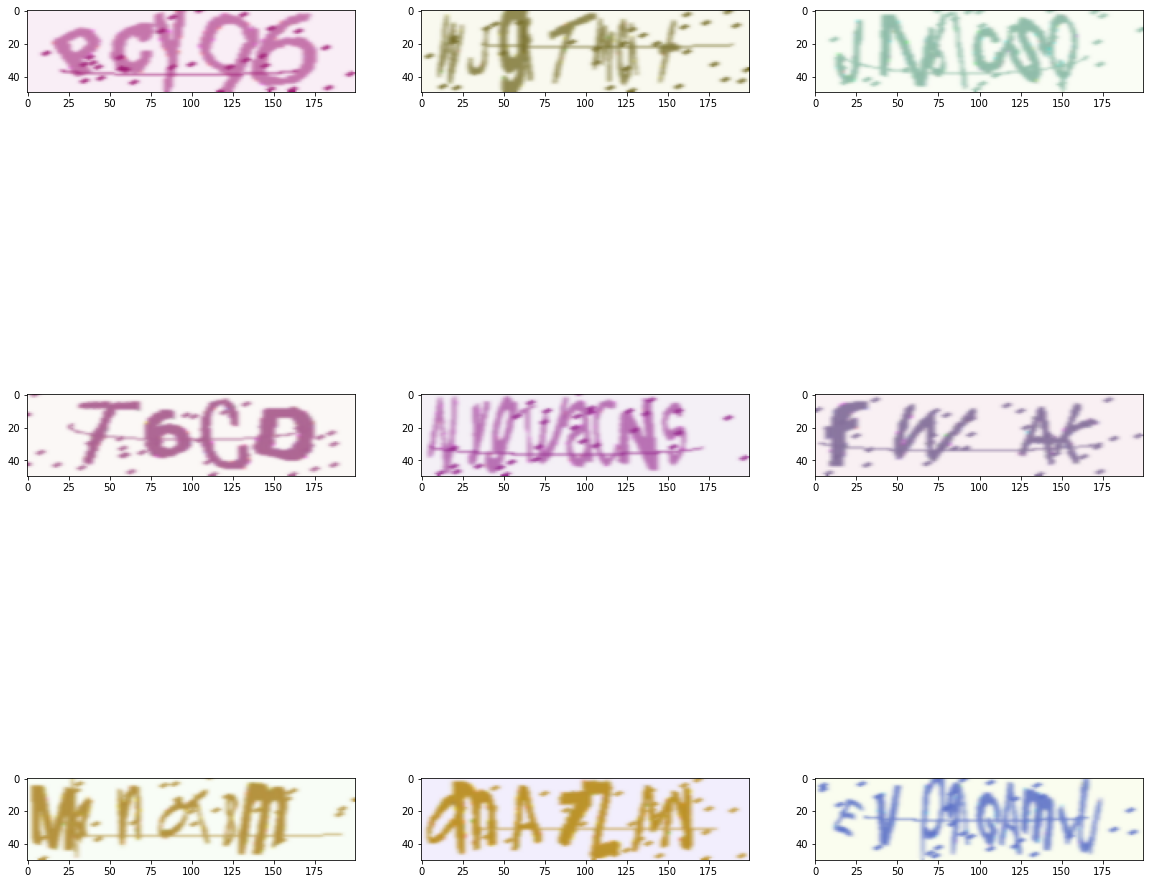

In [10]:
fig=plt.figure(figsize=(20,20))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = train_images_path + train_info['filename'][i]
    label = train_info['label'][i]
    fig.add_subplot(rows, columns, i)
    plot_image(img)
    print(label)
plt.show()

## 2. Define character maps

In [11]:
labels = [x for x in train_info['label']]
labels = ''.join(labels)
letters = sorted(list(set(labels)))
len(letters) # 26 lower case + 26 upper case + 10 digits

62

In [12]:
vocabulary = ['-'] + letters
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
char2idx = {k:v for v,k in enumerate(vocabulary, start=0)}
num_characters = len(vocabulary)

## 3. Define data loader

In [13]:
class CAPTCHADataset(Dataset):
    
    def __init__(self, data_dir, image_infos):
        self.data_dir = data_dir
        self.image_infos = image_infos
        
    def __len__(self):
        return self.image_infos.shape[0]
    
    def __getitem__(self, index):
        filename_label = self.image_infos.iloc[index]
        image_fp = self.data_dir + filename_label['filename']
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        label = filename_label['label']
        return image, label
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.Resize((50, 200)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            
        ])
        return transform_ops(image)

In [14]:
class CAPTCHAtestDataset(Dataset):
    
    def __init__(self, data_dir, image_infos):
        self.data_dir = data_dir
        self.image_infos = image_infos
        
    def __len__(self):
        return self.image_infos.shape[0]
    
    def __getitem__(self, index):
        filename = self.image_infos.iloc[index]
        image_fp = self.data_dir + filename['filename']
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        return image, filename['filename']
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.Resize((50, 200)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            
        ])
        return transform_ops(image)

In [15]:
trainset = CAPTCHADataset(train_images_path, X_train)
validationset = CAPTCHADataset(train_images_path, X_val)
testset = CAPTCHAtestDataset(test_images_path, test_info)

train_loader = DataLoader(trainset, batch_size=config['batch_size'], num_workers=cpu_count, shuffle=True)
validation_loader = DataLoader(validationset, batch_size=config['batch_size'], num_workers=cpu_count, shuffle=True)
test_loader = DataLoader(testset, batch_size=config['batch_size'], num_workers=cpu_count, shuffle=False)
print(len(train_loader), len(validation_loader), len(test_loader))

282 32 157


In [16]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([32, 3, 50, 200]) ('VBCSK', 'HVHqOIHz3U', 'E3qZt', '2fZC5yL', '7zfl3xAT5G', '7fUZx5r', '7Fb7W', 'RjcMFvxvt', 'pGlq', 'GYSI54sGv', 'Lr0M4P9', 'PVL54ur', 'yzqX', 'lpSW', 'Rb3bLK', 'Nwg1XEX', 'TPSsn8631', 'MOSXWRW0a', 'VsFqhDe', 'enZCCvq', 'NO3syxLl', '2eKKzywYlm', 'HXyJ6g', 'GW3pVJ1', 'OpEB', 'UlVXT', 'eFXw2GBgs', 'ReA1', 'XwZyj', 'GJjjLLA8HF', 'Fu4eR', 'moJwhr')


## 4. Define model

In [17]:
num_chars = len(char2idx)
print(num_chars)
rnn_hidden_size = 256

63


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [19]:
resnet = resnet18(pretrained=True)
print(resnet)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [20]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, x):
        
        x = self.cnn_p1(x)
        x = x.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
         
        batch_size = x.size(0)
        T = x.size(1)
        x = x.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        
        x = F.relu(self.linear1(x))
        
        x, hidden = self.rnn1(x)
        feature_size = x.size(2)
        x = x[:, :, :feature_size//2] + x[:, :, feature_size//2:]
        
        x, hidden = self.rnn2(x)
        
        x = self.linear2(x)
        
        out = x.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        
        return out

In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [22]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [23]:
crnn

CRNN(
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [24]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('VBCSK', 'HVHqOIHz3U', 'E3qZt', '2fZC5yL', '7zfl3xAT5G', '7fUZx5r', '7Fb7W', 'RjcMFvxvt', 'pGlq', 'GYSI54sGv', 'Lr0M4P9', 'PVL54ur', 'yzqX', 'lpSW', 'Rb3bLK', 'Nwg1XEX', 'TPSsn8631', 'MOSXWRW0a', 'VsFqhDe', 'enZCCvq', 'NO3syxLl', '2eKKzywYlm', 'HXyJ6g', 'GW3pVJ1', 'OpEB', 'UlVXT', 'eFXw2GBgs', 'ReA1', 'XwZyj', 'GJjjLLA8HF', 'Fu4eR', 'moJwhr')
torch.Size([13, 32, 63])


## 5. Define loss

In [25]:
criterion = nn.CTCLoss(blank=0)

In [26]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [27]:
def compute_loss(text_batch, text_batch_logits, device):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
#     print(text_batch_logits.shape)

    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 

    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)
    return loss

In [28]:
compute_loss(text_batch, text_batch_logits, device)

tensor(7.0536, device='cuda:0', grad_fn=<MeanBackward0>)

## 6. Train model

In [37]:
num_epochs = config['epochs']
lr = config['lr']
weight_decay = config['weight_decay']
clip_norm = config['clip_norm']

In [41]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [42]:
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [43]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
val_losses = []
best_val_loss = 1000
for epoch in tqdm(range(1, num_epochs+1)):
    crnn.train()
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits, device)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    with torch.no_grad():
        val_loss_all = 0
        for image_batch, text_batch in validation_loader:
            image_batch = image_batch.to(device)
            crnn.eval()

            text_batch_logits = crnn(image_batch)
            val_loss = compute_loss(text_batch, text_batch_logits, device)
            val_loss = val_loss.item()
            if np.isnan(val_loss) or np.isinf(val_loss):
                continue
            val_loss_all += val_loss
        if val_loss_all < best_val_loss:
            print("Saving model!")
            best_val_loss = val_loss_all
            torch.save(crnn, 'model')
        val_losses.append(val_loss_all)

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch: {}    Loss: {}    NumUpdates: {}     Validation loss: {}".format(epoch, epoch_loss, num_updates_epoch, val_losses[-1]))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

Saving model!
Epoch: 1    Loss: 4.176975779499568    NumUpdates: 282     Validation loss: 103.88614106178284


Epoch: 2    Loss: 2.2141608764939273    NumUpdates: 282     Validation loss: 110.51150035858154


Saving model!
Epoch: 3    Loss: 1.4317936292776825    NumUpdates: 282     Validation loss: 44.660985827445984


Saving model!
Epoch: 4    Loss: 1.1317061494428216    NumUpdates: 282     Validation loss: 41.43016856908798


Saving model!
Epoch: 5    Loss: 0.9680779787665563    NumUpdates: 282     Validation loss: 40.78804636001587


Epoch: 6    Loss: 0.8690012033949507    NumUpdates: 282     Validation loss: 60.003971457481384


Saving model!
Epoch: 7    Loss: 0.7953862324885442    NumUpdates: 282     Validation loss: 34.892146706581116


Saving model!
Epoch: 8    Loss: 0.7299966821645169    NumUpdates: 282     Validation loss: 31.24724531173706


Epoch: 9    Loss: 0.6992205156290785    NumUpdates: 282     Validation loss: 33.266971945762634


Epoch: 10    Loss: 0.6380397511500839    NumUpdates: 282     Validation loss: 57.52688252925873


Saving model!
Epoch: 11    Loss: 0.6286499791956962    NumUpdates: 282     Validation loss: 29.522031128406525


Saving model!
Epoch: 12    Loss: 0.5921514282623926    NumUpdates: 282     Validation loss: 28.78710800409317


Epoch: 13    Loss: 0.5612885489108714    NumUpdates: 282     Validation loss: 32.32264494895935


Epoch: 14    Loss: 0.5539835295144547    NumUpdates: 282     Validation loss: 105.23845028877258


Epoch: 15    Loss: 0.5272125740211906    NumUpdates: 282     Validation loss: 29.04474413394928


Epoch: 16    Loss: 0.5079214555997376    NumUpdates: 282     Validation loss: 29.952329337596893


Saving model!
Epoch: 17    Loss: 0.49498061603265453    NumUpdates: 282     Validation loss: 28.348989188671112


Epoch: 18    Loss: 0.48190917476271905    NumUpdates: 282     Validation loss: 33.177078902721405


Epoch: 19    Loss: 0.4522262022216269    NumUpdates: 282     Validation loss: 33.7601432800293


Epoch: 20    Loss: 0.4477050984476475    NumUpdates: 282     Validation loss: 58.537445068359375


Saving model!
Epoch: 21    Loss: 0.43401609868445296    NumUpdates: 282     Validation loss: 26.714508593082428


Epoch: 22    Loss: 0.4324657386499094    NumUpdates: 282     Validation loss: 28.922061264514923


Epoch: 23    Loss: 0.41834977316729566    NumUpdates: 282     Validation loss: 27.79527649283409


Epoch: 24    Loss: 0.40174294780966235    NumUpdates: 282     Validation loss: 30.761827290058136


Epoch: 25    Loss: 0.3801792011933124    NumUpdates: 282     Validation loss: 28.55826038122177


Epoch: 26    Loss: 0.3879971095222108    NumUpdates: 282     Validation loss: 58.915106654167175


Epoch: 27    Loss: 0.37050376208961433    NumUpdates: 282     Validation loss: 42.378238916397095


Epoch: 28    Loss: 0.38503018243515746    NumUpdates: 282     Validation loss: 31.976913452148438


Epoch: 29    Loss: 0.3623398410301682    NumUpdates: 282     Validation loss: 33.05825001001358


Epoch: 30    Loss: 0.3646409809060976    NumUpdates: 282     Validation loss: 27.30571359395981


Epoch: 31    Loss: 0.35477728438926925    NumUpdates: 282     Validation loss: 35.34756684303284


Epoch: 32    Loss: 0.3473328875100359    NumUpdates: 282     Validation loss: 32.51734006404877


Epoch: 33    Loss: 0.34043554427987294    NumUpdates: 282     Validation loss: 45.976922392845154


Epoch: 34    Loss: 0.3316543833055395    NumUpdates: 282     Validation loss: 30.989139318466187


Epoch: 35    Loss: 0.3337195910883288    NumUpdates: 282     Validation loss: 31.106813311576843


Epoch: 36    Loss: 0.32484392515311006    NumUpdates: 282     Validation loss: 29.88858073949814


Epoch: 37    Loss: 0.3007475883297041    NumUpdates: 282     Validation loss: 28.159176528453827


Epoch: 38    Loss: 0.32048505771878766    NumUpdates: 282     Validation loss: 38.33583623170853


Epoch: 39    Loss: 0.2994675321887571    NumUpdates: 282     Validation loss: 29.071118235588074


Epoch: 40    Loss: 0.3023009480419734    NumUpdates: 282     Validation loss: 33.24218100309372


Epoch: 41    Loss: 0.2932997060847198    NumUpdates: 282     Validation loss: 32.13268405199051


Epoch: 42    Loss: 0.29748388469641934    NumUpdates: 282     Validation loss: 30.47721838951111


Epoch: 43    Loss: 0.2779788764867377    NumUpdates: 282     Validation loss: 30.87771201133728


Epoch: 44    Loss: 0.29348034596612266    NumUpdates: 282     Validation loss: 37.871550381183624


Epoch: 45    Loss: 0.2932457871576573    NumUpdates: 282     Validation loss: 31.256058037281036


Epoch: 46    Loss: 0.2944719910833007    NumUpdates: 282     Validation loss: 29.86517035961151


Epoch: 47    Loss: 0.265564463874127    NumUpdates: 282     Validation loss: 31.330129027366638


Epoch: 48    Loss: 0.27504469406731585    NumUpdates: 282     Validation loss: 31.329218089580536


Epoch: 49    Loss: 0.2693985807874524    NumUpdates: 282     Validation loss: 30.598739951848984


Epoch: 50    Loss: 0.2741506778707741    NumUpdates: 282     Validation loss: 99.07579183578491



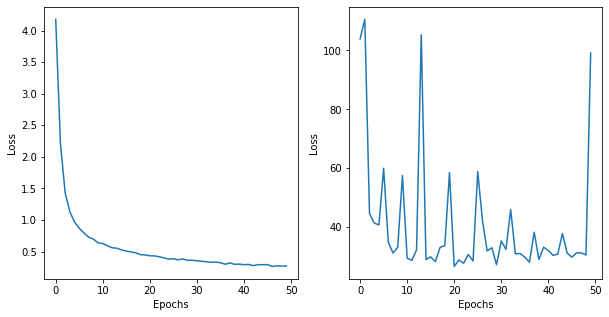

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(val_losses)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")

plt.show()

## 7. Make predictions

In [45]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [46]:
model = torch.load('model')
model.eval()
results_train = pd.DataFrame(columns=['actual', 'prediction'])
# train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = model(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

In [47]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
# test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(validation_loader):
        text_batch_logits = model(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

In [48]:
print(results_train.shape)
results_train.head()

(9000, 2)


,actual,prediction
0,pKkn9YV,p--Kknn9Y-V--
1,MAYKA,-M-A--Y-K-A--
2,qigHjEguW,qigHjE-gu-W--
3,3AmMH93,3-Am-M-H9-3--
4,HnrOpK,-HHn-rO-p-K--


In [49]:
print(results_test.shape)
results_test.head()

(1000, 2)


,actual,prediction
0,0neh,-O-n-e--h----
1,17T2Pb,-1-7--T2-Pb--
2,ssHTOn,5---sH-T-O-n-
3,c0mPPJaJ,c-0m-P-PJaU--
4,NlyT7,--N-Iy-TTT---


In [51]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)


def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [52]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,prediction_corrected
0,pKkn9YV,p--Kknn9Y-V--,pKkn9YV
1,MAYKA,-M-A--Y-K-A--,MAYKA
2,qigHjEguW,qigHjE-gu-W--,qigHjEguW
3,3AmMH93,3-Am-M-H9-3--,3AmMH93
4,HnrOpK,-HHn-rO-p-K--,HnrOpK


In [53]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,0neh,-O-n-e--h----,Oneh
1,17T2Pb,-1-7--T2-Pb--,17T2Pb
2,ssHTOn,5---sH-T-O-n-,5sHTOn
3,c0mPPJaJ,c-0m-P-PJaU--,c0mPPJaU
4,NlyT7,--N-Iy-TTT---,NIyT


## 8. Evaluate the model

In [54]:
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
0,0neh,-O-n-e--h----,Oneh
2,ssHTOn,5---sH-T-O-n-,5sHTOn
3,c0mPPJaJ,c-0m-P-PJaU--,c0mPPJaU
4,NlyT7,--N-Iy-TTT---,NIyT
5,NackeZOxNk,N-dceZBxIVk--,NdceZBxIVk
...,...,...,...
994,nD6izquz,n-D5Izq-uuz--,nD5Izquz
995,mF95zk92jK,4-F95zk921K--,4F95zk921K
996,Hsjx0Ecs8,h-Shx-0Ecs-8-,hShx0Ecs8
997,xYYrS3vDTd,x-YYrSvv0Td--,xYrSv0Td


In [55]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

8     145
7     133
9     127
6     105
5      97
10     77
4      67
3       9
11      4
Name: prediction_corrected, dtype: int64


In [56]:
mask = mistakes_df['prediction_corrected'].str.len() == 5
mistakes_df[mask]

,actual,prediction,prediction_corrected
9,tQgXT,-t-Q-g-x-T---,tQgxT
10,yWAnc,--y--WA-nt---,yWAnt
20,n35vPnR,-35-i---n-R--,35inR
25,SNjoO,--S-N-jo--0--,SNjo0
28,69NJJ,--6-9-NU-J---,69NUJ
...,...,...,...
969,pVhsx,--p-v-h-s-X--,pvhsX
972,4cfmQ,-4c-x-m-Q----,4cxmQ
975,38oh1,3-8-O-h--1---,38Oh1
979,y1XRcO,yy-x-RC-m----,yxRCm


In [ ]:
mistake_image_fp = os.path.join(data_path, mistakes_df[mask]['actual'].values[0] + ".png")
print(mistake_image_fp)
mistake_image = Image.open(mistake_image_fp)
plt.imshow(mistake_image)
plt.show()

In [57]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print(test_accuracy)

0.4832222222222222
0.236


In [58]:
results_test = pd.DataFrame(columns=['filename', 'label'])
# test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, filename_batch in tqdm(test_loader):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['filename', 'label'])
        df['label'] = text_batch_pred
        df['filename'] = filename_batch
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

In [59]:
results_test.head()

,filename,label
0,image_10001.png,--GiiO-QjzzJ1
1,image_10002.png,I3-6TOorJJrr-
2,image_10003.png,jj0vK5XJy9CJy
3,image_10004.png,fgk----Vjnj71
4,image_10005.png,I-A-3lc--yylI


In [60]:
results_test['label'] = results_test['label'].apply(correct_prediction)
results_test.head()

,filename,label
0,image_10001.png,GiOQjzJ1
1,image_10002.png,I36TOorJr
2,image_10003.png,j0vK5XJy9CJy
3,image_10004.png,fgkVjnj71
4,image_10005.png,IA3lcylI


In [61]:
results_test.to_csv('captcha_submission.csv')
from google.colab import files
files.download('captcha_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
create_download_link(results_test)